In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    #generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  8820 
test set size:  1047


In [5]:
model: torch.nn.Module = build_model(
    cat_dim=cfg_model.cat_dim,
    latent_space_dim=cfg_model.z_dim,
    hidden_dim=cfg_model.hidden_dim,
    loss_weights=cfg_model.loss_weights,
    expert_type=cfg_model.expert_type,
    use_cuda=True
).double()

In [6]:
training_losses = train(
    mvae_model=model,
    dataset_loader=dataset_loader,
    learning_rate=cfg_train.learning_rate,
    optim_betas=cfg_train.optim_betas,
    num_epochs=cfg_train.num_epochs,
    batch_size=cfg_train.batch_size,
    checkpoint_every=cfg_train.checkpoint_every,
    checkpoint_path=cfg_train.checkpoint_path,
    save_model=cfg_train.save_model,
    seed=cfg_train.seed,
    use_cuda=cfg_train.use_cuda,
    cfg=cfg_train
)

  2%|▏      | 1/50 [02:48<2:18:00, 168.99s/it]

Mean total loss: 3.3103;
Mean all modalities loss: 4.6493;
Mean faces loss: 1.217;
Mean emotions loss: 4.0646;



  4%|▎      | 2/50 [05:35<2:14:13, 167.77s/it]

Mean total loss: 2.8877;
Mean all modalities loss: 3.9856;
Mean faces loss: 0.80291;
Mean emotions loss: 3.8747;



  6%|▍      | 3/50 [08:17<2:09:21, 165.14s/it]

Mean total loss: 2.5803;
Mean all modalities loss: 3.5614;
Mean faces loss: 0.60144;
Mean emotions loss: 3.5782;



  8%|▌      | 4/50 [11:02<2:06:21, 164.81s/it]

Mean total loss: 2.2763;
Mean all modalities loss: 3.2217;
Mean faces loss: 0.46339;
Mean emotions loss: 3.1439;



 10%|▋      | 5/50 [13:55<2:05:49, 167.77s/it]

Mean total loss: 1.9647;
Mean all modalities loss: 2.8937;
Mean faces loss: 0.36644;
Mean emotions loss: 2.634;



 12%|▊      | 6/50 [16:36<2:01:20, 165.47s/it]

Mean total loss: 1.7215;
Mean all modalities loss: 2.5828;
Mean faces loss: 0.28546;
Mean emotions loss: 2.2962;



 14%|▉      | 7/50 [19:30<2:00:35, 168.28s/it]

Mean total loss: 1.6031;
Mean all modalities loss: 2.41;
Mean faces loss: 0.23864;
Mean emotions loss: 2.1606;



 16%|█      | 8/50 [22:11<1:56:17, 166.13s/it]

Mean total loss: 1.5422;
Mean all modalities loss: 2.3289;
Mean faces loss: 0.20781;
Mean emotions loss: 2.0898;



 18%|█▎     | 9/50 [24:38<1:49:19, 160.00s/it]

Mean total loss: 1.5103;
Mean all modalities loss: 2.2883;
Mean faces loss: 0.19217;
Mean emotions loss: 2.0505;



 20%|█▏    | 10/50 [27:14<1:45:48, 158.72s/it]

Mean total loss: 1.4894;
Mean all modalities loss: 2.2612;
Mean faces loss: 0.18187;
Mean emotions loss: 2.0252;



 22%|█▎    | 11/50 [29:49<1:42:25, 157.58s/it]

Mean total loss: 1.4661;
Mean all modalities loss: 2.2308;
Mean faces loss: 0.17191;
Mean emotions loss: 1.9955;



 24%|█▍    | 12/50 [32:24<1:39:22, 156.91s/it]

Mean total loss: 1.4431;
Mean all modalities loss: 2.2037;
Mean faces loss: 0.16537;
Mean emotions loss: 1.9602;



 26%|█▌    | 13/50 [34:56<1:35:51, 155.44s/it]

Mean total loss: 1.419;
Mean all modalities loss: 2.1699;
Mean faces loss: 0.15999;
Mean emotions loss: 1.9272;



 28%|█▋    | 14/50 [37:31<1:33:05, 155.15s/it]

Mean total loss: 1.3892;
Mean all modalities loss: 2.1322;
Mean faces loss: 0.15478;
Mean emotions loss: 1.8807;



 30%|█▊    | 15/50 [40:04<1:30:09, 154.57s/it]

Mean total loss: 1.3511;
Mean all modalities loss: 2.078;
Mean faces loss: 0.14985;
Mean emotions loss: 1.8253;



 32%|█▉    | 16/50 [42:32<1:26:25, 152.53s/it]

Mean total loss: 1.3105;
Mean all modalities loss: 2.0254;
Mean faces loss: 0.14591;
Mean emotions loss: 1.76;



 34%|██    | 17/50 [44:46<1:20:48, 146.93s/it]

Mean total loss: 1.2677;
Mean all modalities loss: 1.9577;
Mean faces loss: 0.14301;
Mean emotions loss: 1.7024;



 36%|██▏   | 18/50 [47:04<1:16:57, 144.31s/it]

Mean total loss: 1.2199;
Mean all modalities loss: 1.8908;
Mean faces loss: 0.13875;
Mean emotions loss: 1.63;



 38%|██▎   | 19/50 [49:15<1:12:35, 140.50s/it]

Mean total loss: 1.1674;
Mean all modalities loss: 1.8108;
Mean faces loss: 0.1374;
Mean emotions loss: 1.5539;



 40%|██▍   | 20/50 [51:17<1:07:26, 134.87s/it]

Mean total loss: 1.1181;
Mean all modalities loss: 1.7336;
Mean faces loss: 0.13481;
Mean emotions loss: 1.4858;



 42%|██▌   | 21/50 [53:15<1:02:42, 129.76s/it]

Mean total loss: 1.0715;
Mean all modalities loss: 1.6604;
Mean faces loss: 0.13289;
Mean emotions loss: 1.4211;



 44%|███▌    | 22/50 [55:21<59:58, 128.53s/it]

Mean total loss: 1.0272;
Mean all modalities loss: 1.5881;
Mean faces loss: 0.13009;
Mean emotions loss: 1.3634;



 46%|███▋    | 23/50 [57:30<57:55, 128.73s/it]

Mean total loss: 0.98521;
Mean all modalities loss: 1.5215;
Mean faces loss: 0.12857;
Mean emotions loss: 1.3055;



 48%|███▊    | 24/50 [59:41<56:03, 129.35s/it]

Mean total loss: 0.94818;
Mean all modalities loss: 1.4628;
Mean faces loss: 0.12634;
Mean emotions loss: 1.2555;



 50%|███   | 25/50 [1:01:54<54:25, 130.61s/it]

Mean total loss: 0.90952;
Mean all modalities loss: 1.4087;
Mean faces loss: 0.12369;
Mean emotions loss: 1.1962;



 52%|███   | 26/50 [1:04:06<52:25, 131.06s/it]

Mean total loss: 0.88059;
Mean all modalities loss: 1.3591;
Mean faces loss: 0.12359;
Mean emotions loss: 1.1591;



 54%|███▏  | 27/50 [1:06:20<50:30, 131.75s/it]

Mean total loss: 0.85194;
Mean all modalities loss: 1.3149;
Mean faces loss: 0.12167;
Mean emotions loss: 1.1192;



 56%|███▎  | 28/50 [1:08:28<47:58, 130.83s/it]

Mean total loss: 0.81916;
Mean all modalities loss: 1.2661;
Mean faces loss: 0.11974;
Mean emotions loss: 1.0717;



 58%|███▍  | 29/50 [1:10:39<45:45, 130.73s/it]

Mean total loss: 0.80113;
Mean all modalities loss: 1.2374;
Mean faces loss: 0.11807;
Mean emotions loss: 1.048;



 60%|███▌  | 30/50 [1:12:52<43:49, 131.47s/it]

Mean total loss: 0.77795;
Mean all modalities loss: 1.2034;
Mean faces loss: 0.1169;
Mean emotions loss: 1.0136;



 62%|███▋  | 31/50 [1:15:02<41:26, 130.88s/it]

Mean total loss: 0.75408;
Mean all modalities loss: 1.1624;
Mean faces loss: 0.11607;
Mean emotions loss: 0.98372;



 64%|███▊  | 32/50 [1:17:12<39:13, 130.74s/it]

Mean total loss: 0.74359;
Mean all modalities loss: 1.1445;
Mean faces loss: 0.11472;
Mean emotions loss: 0.97155;



 66%|███▉  | 33/50 [1:19:22<36:59, 130.57s/it]

Mean total loss: 0.73091;
Mean all modalities loss: 1.1333;
Mean faces loss: 0.11411;
Mean emotions loss: 0.9453;



 68%|████  | 34/50 [1:21:32<34:44, 130.29s/it]

Mean total loss: 0.71466;
Mean all modalities loss: 1.1033;
Mean faces loss: 0.11348;
Mean emotions loss: 0.9272;



 70%|████▏ | 35/50 [1:23:45<32:47, 131.16s/it]

Mean total loss: 0.7015;
Mean all modalities loss: 1.0853;
Mean faces loss: 0.11172;
Mean emotions loss: 0.9075;



 72%|████▎ | 36/50 [1:25:52<30:20, 130.02s/it]

Mean total loss: 0.68727;
Mean all modalities loss: 1.0589;
Mean faces loss: 0.11171;
Mean emotions loss: 0.8912;



 74%|████▍ | 37/50 [1:28:07<28:27, 131.37s/it]

Mean total loss: 0.67921;
Mean all modalities loss: 1.0494;
Mean faces loss: 0.11041;
Mean emotions loss: 0.87783;



 76%|████▌ | 38/50 [1:30:18<26:15, 131.32s/it]

Mean total loss: 0.67005;
Mean all modalities loss: 1.0398;
Mean faces loss: 0.10962;
Mean emotions loss: 0.86069;



 78%|████▋ | 39/50 [1:32:29<24:04, 131.28s/it]

Mean total loss: 0.66434;
Mean all modalities loss: 1.024;
Mean faces loss: 0.10874;
Mean emotions loss: 0.86026;



 80%|████▊ | 40/50 [1:34:42<21:58, 131.86s/it]

Mean total loss: 0.65471;
Mean all modalities loss: 1.017;
Mean faces loss: 0.10802;
Mean emotions loss: 0.83915;



 82%|████▉ | 41/50 [1:36:52<19:39, 131.04s/it]

Mean total loss: 0.65042;
Mean all modalities loss: 1.0053;
Mean faces loss: 0.10743;
Mean emotions loss: 0.83856;



 84%|█████ | 42/50 [1:39:03<17:29, 131.17s/it]

Mean total loss: 0.64312;
Mean all modalities loss: 1.0034;
Mean faces loss: 0.10644;
Mean emotions loss: 0.81951;



 86%|█████▏| 43/50 [1:41:07<15:02, 128.90s/it]

Mean total loss: 0.63534;
Mean all modalities loss: 0.98557;
Mean faces loss: 0.10625;
Mean emotions loss: 0.81421;



 88%|█████▎| 44/50 [1:43:15<12:52, 128.79s/it]

Mean total loss: 0.63004;
Mean all modalities loss: 0.97699;
Mean faces loss: 0.10643;
Mean emotions loss: 0.80672;



 90%|█████▍| 45/50 [1:45:28<10:49, 129.98s/it]

Mean total loss: 0.62242;
Mean all modalities loss: 0.96759;
Mean faces loss: 0.10472;
Mean emotions loss: 0.79494;



 92%|█████▌| 46/50 [1:47:40<08:42, 130.52s/it]

Mean total loss: 0.61803;
Mean all modalities loss: 0.95908;
Mean faces loss: 0.10439;
Mean emotions loss: 0.79061;



 94%|█████▋| 47/50 [1:49:47<06:28, 129.42s/it]

Mean total loss: 0.61363;
Mean all modalities loss: 0.95009;
Mean faces loss: 0.10438;
Mean emotions loss: 0.78641;



 96%|█████▊| 48/50 [1:51:59<04:20, 130.39s/it]

Mean total loss: 0.60885;
Mean all modalities loss: 0.94704;
Mean faces loss: 0.10282;
Mean emotions loss: 0.77671;



 98%|█████▉| 49/50 [1:54:11<02:10, 130.75s/it]

Mean total loss: 0.60318;
Mean all modalities loss: 0.94215;
Mean faces loss: 0.103;
Mean emotions loss: 0.7644;



100%|██████| 50/50 [1:56:20<00:00, 139.61s/it]

Mean total loss: 0.5981;
Mean all modalities loss: 0.92956;
Mean faces loss: 0.10287;
Mean emotions loss: 0.76187;



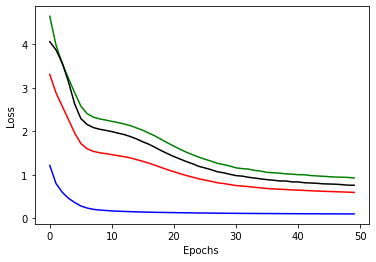

In [7]:
plt.ylabel("Loss ")
plt.xlabel("Epochs ")
plt.plot(training_losses['total_loss'], color='red')
plt.plot(training_losses['multimodal_loss'], color='green')
plt.plot(training_losses['faces_loss'], color='blue')
plt.plot(training_losses['emotions_loss'], color='black')

In [8]:
def testBatch(model, dataset_loader, img_size=64, use_cuda=True):
    sample = next(iter(dataset_loader))
    images = sample['image']
    labels = sample['cat']
    
    if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
        
    input_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_emotions = []

    batch_size = images.shape[0]
    
    reconstructed_images, reconstructed_emotions, _, _ = model(faces=images, emotions=labels)

    for idx in range(4):
        input_image = images[idx]
        
        # storing the input image
        input_image_display = np.array(input_image.cpu()*255., dtype='uint8').transpose((1, 2, 0))
        input_array = np.concatenate((input_array, input_image_display), axis=1)
        
        # generating the reconstructed image and adding to array
        input_image = input_image.view(1, 3, img_size, img_size)
        
        reconstructed_img = reconstructed_images[idx].cpu().view(3, img_size, img_size).detach().numpy()
        reconstructed_img = np.array(reconstructed_img*255., dtype='uint8').transpose((1, 2, 0))
        reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)
        
    # remove first, blank column, and concatenate
    input_array = input_array[:,1:,:]
    reconstructed_array = reconstructed_array[:,1:,:]
    display_array = np.concatenate((input_array, reconstructed_array), axis=0)
    plt.imshow(display_array)
    
    print([Rd.emocat[label.item()] for label in labels[:4]])
    print([Rd.emocat[emo.item()] for emo in torch.argmax(reconstructed_emotions, 1)[:4]])

['surprised', 'happy', 'fearful', 'surprised']
['surprised', 'happy', 'fearful', 'surprised']


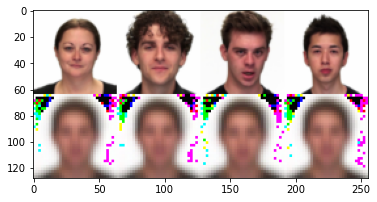

In [9]:
testBatch(model, dataset_loader)

In [10]:
from tqdm import tqdm
def emotion_accuracy(model, dataset_loader):
    
    match = 0
    total = 0
    
    for sample in tqdm(iter(dataset_loader)):
        labels = sample['cat'].cuda()
                            
        _, reconstructed_emotions, _, _ = model(faces=None, emotions=labels)  
        emotion_cat = torch.argmax(reconstructed_emotions, 1)  
        
        for idx in range(len(labels)):
            total += 1
            if labels[idx] == emotion_cat[idx]:
                match += 1
    
    acc = match / total
    return acc

In [11]:
print(emotion_accuracy(model, testset_loader))

100%|█████████████████| 33/33 [00:17<00:00,  1.84it/s]

0.938872970391595


In [ ]:
if save_model:
    # Do a global and a local save of the model (local to Hydra outputs)
    torch.save(mvae_model.state_dict(), cfg.model_save_path)
    torch.save(mvae_model.state_dict(), "ravdess_mvae_pretrained.pt")
    logger.info(f"Saved model to '{cfg.train.plain.model_save_path}', and also locally.")

    # Do a global and local save of the training stats (local to Hydra outputs)
    torch.save(training_losses, cfg.stats_save_path)
    torch.save(training_losses, "ravdess_mvae_pretrained_stats.pt")
    logger.info(f"Saved model to '{cfg.train.plain.stats_save_path}', and also locally.")
